In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import os
import pandas as pd

# Dataset yolunu belirt
dir  = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'


label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':          
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [26]:
df.head(3)

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [27]:
from sklearn.model_selection import train_test_split
# Veriyi %80 eğitim ve %20 test olarak ayır
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Sonuçları kontrol et
print(f'Toplam veri sayısı: {len(df)}')
print(f'Eğitim verisi sayısı: {len(train_df)}')
print(f'Test verisi sayısı: {len(test_df)}')

Toplam veri sayısı: 9000
Eğitim verisi sayısı: 7200
Test verisi sayısı: 1800


**Modelin Eğitilmesi**

In [30]:
# Resim verilerini yüklemek için bir fonksiyon
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

# Eğitim ve test verilerini yükle
X_train = load_images(train_df['path'].values)
X_test = load_images(test_df['path'].values)

# Label'ları sayısal değerlere çevirelim (Label Encoding)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [31]:
# Modeli oluştur
model = Sequential()

In [34]:

# 1. Katman: 128x128x3 resimler düzleştiriliyor (Flatten)
model.add(Flatten(input_shape=(128, 128, 3)))

# 2. Katman: 512 nöron, ReLU aktivasyonu, Dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# 3. Katman: 256 nöron, ReLU aktivasyonu, Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# 4. Katman: 128 nöron, ReLU aktivasyonu
model.add(Dense(128, activation='relu'))

# Çıkış Katmanı: Softmax aktivasyonu, sınıf sayısı kadar çıkış
model.add(Dense(y_train.shape[1], activation='softmax'))


In [35]:
# Modeli derle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini yazdır
model.summary()

# Veri artırma (Data Augmentation) ile eğitim verisini çeşitlendirme
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Modeli eğit
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20, 
                    validation_data=(X_test, y_test))

# Modeli test et
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Modeli kaydetmek isterseniz
model.save('fish_classifier_ann.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,672,731 (97.93 MB)

 Trainable params: 25,672,731 (97.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 76s 313ms/step - accuracy: 0.1073 - loss: 2.1997 - val_accuracy: 0.1111 - val_loss: 2.1974
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - accuracy: 0.1048 - loss: 2.1990 - val_accuracy: 0.1111 - val_loss: 2.1974
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - accuracy: 0.1056 - loss: 2.1982 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - accuracy: 0.1033 - loss: 2.1979 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - accuracy: 0.1127 - loss: 2.1975 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 100s 442ms/step - accuracy: 0.1006 - loss: 2.1975 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 75s 327ms/step - accuracy: 0.1118 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 74s 325ms/step - accuracy: 0.1133 - loss: 2.1971 - va

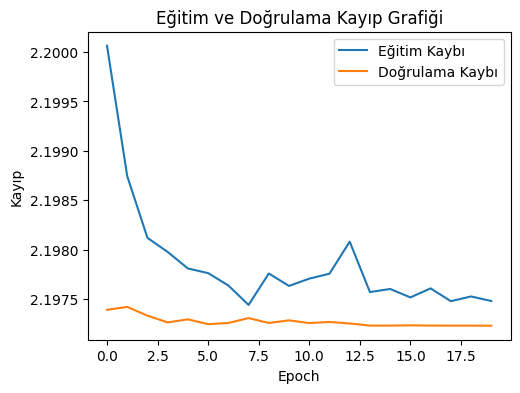

In [36]:
import matplotlib.pyplot as plt
# Eğitim ve doğrulama süreçlerinin doğruluk ve kayıp metriklerinin grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama kaybı (loss) grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

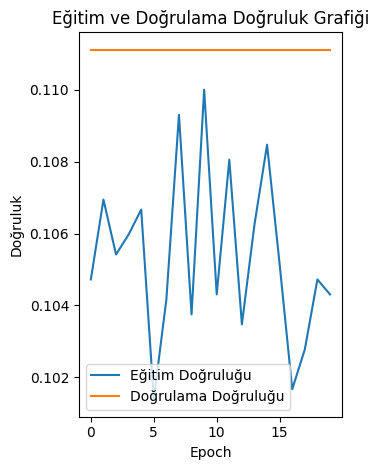

In [37]:

# Eğitim ve doğrulama doğruluğu (accuracy) grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Grafikleri göster
plt.tight_layout()
plt.show()


In [ ]:
import keras_tuner as kt

# Hiperparametre ayarlamaları için model oluşturma fonksiyonu
def build_model(hp):
    model = Sequential()

    # 1. Katman: 128x128x3 resimler düzleştiriliyor (Flatten)
    model.add(Flatten(input_shape=(128, 128, 3)))

    # Hiperparametre olarak katman sayısı ve her katmandaki nöron sayısını ayarlama
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 ile 3 arasında değişen katman sayısı
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=512, step=64), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1)))

    # Çıkış katmanı: sınıf sayısı kadar çıkış
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Optimizer'ı hiperparametre olarak ayarlama
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Modeli derleme
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# KerasTuner ile hiperparametre araması yapma
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Hedeflenen ölçüt: doğrulama doğruluğu
    max_trials=10,  # Deneme sayısı
    executions_per_trial=1,  # Her denemede kaç model eğitilecek
    directory='tuner_dir',  # Sonuçlar kaydedilecek dizin
    project_name='fish_classifier_tuning')

# Tuner'ı eğitmek
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# En iyi modelin sonuçları
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'En iyi katman sayısı: {best_hps.get("num_layers")}')
for i in range(best_hps.get('num_layers')):
    print(f'Katman {i+1} nöron sayısı: {best_hps.get("units_" + str(i))}')
    print(f'Katman {i+1} dropout oranı: {best_hps.get("dropout_" + str(i))}')

print(f'En iyi optimizer: {best_hps.get("optimizer")}')

# En iyi hiperparametrelerle yeni model oluşturma ve eğitme
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Trial 6 Complete [00h 05m 18s]
val_accuracy: 0.24833333492279053

Best val_accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 32m 59s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
3                 |1                 |num_layers
64                |192               |units_0
0.2               |0.2               |dropout_0
rmsprop           |sgd               |optimizer
320               |384               |units_1
0.5               |0.1               |dropout_1
64                |64                |units_2
0.2               |0.2               |dropout_2

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.1079 - loss: 3.9319 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.1084 - loss: 2.1977 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.1130 - loss: 2.1975 - val_accuracy: 0.1111 - val_loss: 2.1973
Epoch 4/